## Face Mask Detection

Juliya Anuash

Lyazzat Zharkynbekkyzy

Renat Abdrakhmanov

BDA-1903

### Content
- Introduction
- Exploratory Data Analysis 
  - Raw Comparison
  - Images as Matrix
  - Average Image
  - Conrast Between Average Images
  - Eigenimages
  
- Data Preparation 
- Data Preprocessing 
- Creating a model
- Model evaluation
- Conclusion


## Introduction

Masks play a crucial role in protecting the health of individuals against respiratory diseases, as is one of the few precautions available for COVID-19 in the absence of immunization. With this dataset, it is possible to create a model to detect people wearing masks, not wearing them, or wearing masks improperly. We use dataset with images from <a href="https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset/code">Kaggle.com</a>. This dataset has 12000 images, which is 6000 with mask and 6000 without mask. 

## EDA

### Raw Comparison
In this step we looking at a few randomly sampled images from each sub-folders:With and Without masks


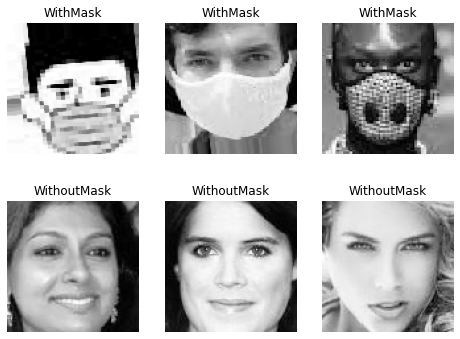

(5000, 5000)

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
%matplotlib inline

train_dir = 'dataset/Face Mask Dataset/Train' # image folder

# get the list of jpegs from sub image class folders
with_imgs = [fn for fn in os.listdir(f'{train_dir}/WithMask') if fn.endswith('.png')]
without_imgs = [fn for fn in os.listdir(f'{train_dir}/WithoutMask') if fn.endswith('.png')]

# randomly select 3 of each
select_with = np.random.choice(with_imgs, 3, replace = False)
select_without = np.random.choice(without_imgs, 3, replace = False)

# plotting 2 x 3 image matrix
fig = plt.figure(figsize = (8,6))
for i in range(6):
    if i < 3:
        fp = f'{train_dir}/WithMask/{select_with[i]}'
        label = 'WithMask'
    else:
        fp = f'{train_dir}/WithoutMask/{select_without[i-3]}'
        label = 'WithoutMask'
    ax = fig.add_subplot(2, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = (100,100), color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

# also check the number of files here
len(with_imgs), len(without_imgs)

### Images as Matrix
In this step we convert our images into Numpy array(pixel values) to make working with images more easier and take matrix(n,m), where n is the number of observations and m is the number of pixels.

In [24]:
# making n X m matrix
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders
with_images = img2np(f'{train_dir}/WithMask/', with_imgs)
without_images = img2np(f'{train_dir}/WithoutMask/', without_imgs)

### Average Image
To take average value of each pixel across all observation, we determine the average image.


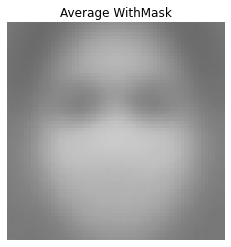

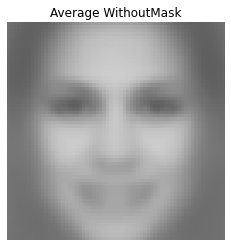

In [25]:
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

with_mean = find_mean_img(with_images, 'WithMask')
without_mean = find_mean_img(without_images, 'WithoutMask')

We can see from the average image that Without masks tend to show higher obstruction around the eyes,mouth and nose area.

### Contrast Between Average Images
We found contrast between average images to see the differences between with and without images.

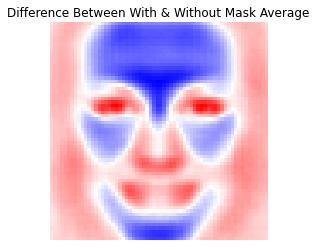

In [26]:
contrast_mean = with_mean - without_mean
plt.imshow(contrast_mean, cmap='bwr')
plt.title(f'Difference Between With & Without Mask Average')
plt.axis('off')
plt.show()

### Eigenimages
Finally, we can visualize the components that better represent each class using a dimension reduction technique such as principal component analysis. The eigenimages of our image matrix, which are basically the eigenvectors of PCA, can be reshaped into a matrix and plotted. For each class, we can visualize the principal components that qualify for 70% of the variability.

Number of PC:  31


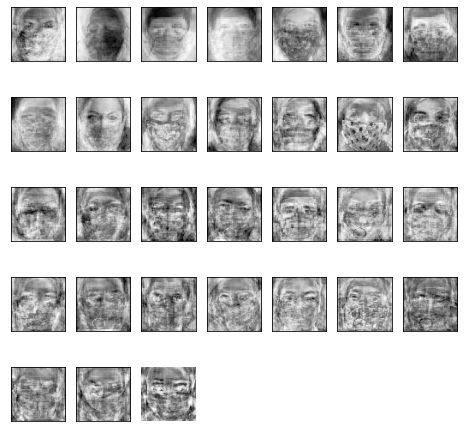

Number of PC:  33


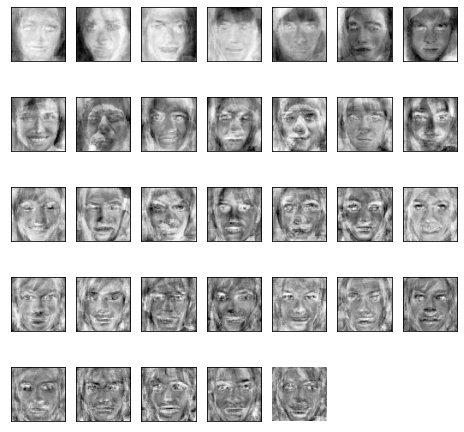

In [27]:
from sklearn.decomposition import PCA
from math import ceil

def eigenimages(full_mat, title, n_comp = 0.95, size = (64, 64)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat[:50])
    print('Number of PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca, size = (64, 64)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()
    
plot_pca(eigenimages(with_images, 'WithMask'))
plot_pca(eigenimages(without_images, 'WithoutMask'))

## Applying set of models

### Importing packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import imageio
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.utils import np_utils
import os

### Process of labelling

With Mask - 1, Without - 0

### Data preparation

We are creating lists with images for training dataset(with,without mask)

In [2]:
train_img = []
train_lbl = []
#create list of images for training dataset with mask
for image in os.listdir('dataset/Face Mask Dataset/Train/WithMask'):
    im = Image.open('dataset/Face Mask Dataset/Train/WithMask/' + image)
    train_img.append(np.asarray(im.resize((100, 100))))
    train_lbl.append(1)
  #create list of images for training dataset without mask  
for image in os.listdir('dataset/Face Mask Dataset/Train/WithoutMask'):
    im = Image.open('dataset/Face Mask Dataset/Train/WithoutMask/' + image)
    train_img.append(np.asarray(im.resize((100, 100))))
    train_lbl.append(0)

We are creating lists with images for test dataset(with,without mask)

In [3]:
test_img = []
test_lbl = []
#create list of images for test dataset with mask
for image in os.listdir('dataset/Face Mask Dataset/Test/WithMask'):
    im = Image.open('dataset/Face Mask Dataset/Test/WithMask/' + image)
    test_img.append(np.asarray(im.resize((100, 100))))
    test_lbl.append(1)
#create list of images for test dataset without mask
for image in os.listdir('dataset/Face Mask Dataset/Test/WithoutMask'):
    im = Image.open('dataset/Face Mask Dataset/Test/WithoutMask/' + image)
    test_img.append(np.asarray(im.resize((100, 100))))
    test_lbl.append(0)

We are creating lists with images for validation dataset(with,without mask)

In [4]:
validation_img = []
validation_lbl = []
#create list of images for validation dataset with mask
for image in os.listdir('dataset/Face Mask Dataset/Validation/WithMask'):
    im = Image.open('dataset/Face Mask Dataset/Validation/WithMask/' + image)
    validation_img.append(np.asarray(im.resize((100, 100))))
    validation_lbl.append(1)
#create list of images for validation dataset without mask    
for image in os.listdir('dataset/Face Mask Dataset/Validation/WithoutMask'):
    im = Image.open('dataset/Face Mask Dataset/Validation/WithoutMask/' + image)
    validation_img.append(np.asarray(im.resize((100, 100))))
    validation_lbl.append(0)

Converting lists to array

In [5]:
#convert lists to numpy array
test_img = np.array(test_img)
train_img = np.array(train_img)
validation_img = np.array(validation_img)

### Data preprocessing

In [6]:
#convert datatype to float32
train_img = train_img.astype('float32')
test_img = test_img.astype('float32')
validation_img = validation_img.astype('float32')
#divide to 255 which is the highest level of the color is evident in the pixel to normalize results.
train_img = train_img / 255.0
test_img = test_img / 255.0
validation_img = validation_img / 255.0

In [7]:
train_lbl = np.array(train_lbl)
test_lbl = np.array(test_lbl)
validation_lbl = np.array(validation_lbl)

np_utils.to_categorical is used to convert array of labeled data to one-hot vector.

In [8]:
#convert array to vector 
train_lbl = np_utils.to_categorical(train_lbl)
test_lbl = np_utils.to_categorical(test_lbl)
validation_lbl = np_utils.to_categorical(validation_lbl)
class_num = test_lbl.shape[1]

In [9]:
#randomly shuffle datasets to filtering the data
indices = np.arange(train_lbl.shape[0])
np.random.shuffle(indices)

train_lbl = train_lbl[indices]
train_img = train_img[indices]

indices1 = np.arange(test_lbl.shape[0])
np.random.shuffle(indices1)

test_lbl = test_lbl[indices1]
test_img = test_img[indices1]

indices2 = np.arange(validation_lbl.shape[0])
np.random.shuffle(indices2)

validation_lbl = validation_lbl[indices2]
validation_img = validation_img[indices2]

### Creating a model (Convolutional Neural Network)

We use the Conv2D class to implement a simple Convolutional Neural Network(CNN). Depending on the complexity of our dataset and  the depth of our neural network we use  filters in the range [32, 64, 128] and kernel size (3,3) which is the width and height of the 2D convolution window. We supply value of same for the padding, because we want to preserve the spatial dimensions of the volume such that the output volume size matches the input volume size.
Each Conv2D is stacked on the network with model.add .
The dropout rate is set to 20%, meaning one in 5 inputs will be randomly excluded from each update cycle.We use BatchNormalization to automatically standardize the inputs to a layer in a deep learning neural network.

In [10]:
# Process of creating a convolutional neural network
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(100, 100, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.3))

model.add(Dense(256, kernel_constraint=maxnorm(3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
    
model.add(Dense(128, kernel_constraint=maxnorm(3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(2, activation='sigmoid'))

In [11]:
# Compiling and getting summary of the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 64)        2

In [15]:
# Model fitting
np.random.seed(21)
model.fit(train_img, train_lbl, validation_data=(validation_img, validation_lbl), epochs=3, batch_size=64)

Epoch 1/3
 18/157 [==>...........................] - ETA: 9:30 - loss: 0.2664 - accuracy: 0.9002

KeyboardInterrupt: 

Jupyter notebook doesn't provide GPU accelerator, thats why we decided to run this code on kaggles kernel.

### Model evaluation

In [12]:
# Use of already uploaded model
saved_model = keras.models.load_model("model.h5")

In [13]:
# Check the model on test set
saved_model.evaluate(test_img, test_lbl)

31/31 [==============================] - 6s 197ms/step - loss: 0.0421 - accuracy: 0.9839


[0.04207450896501541, 0.9838709831237793]

In [14]:
# Save predictions of the model
predictions = saved_model.predict(test_img)

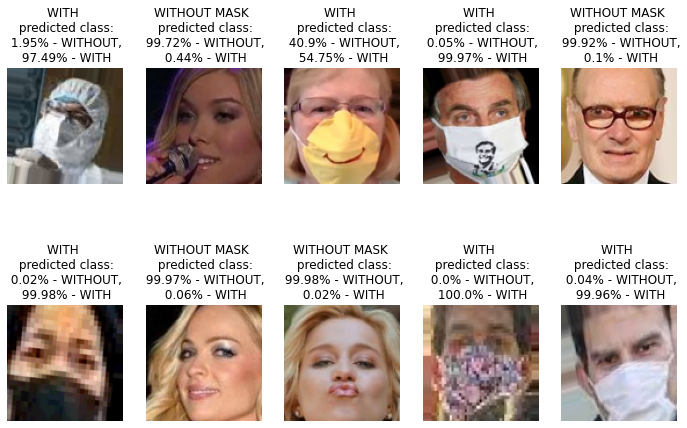

In [15]:
# Plot images with their actual and predicted classes
plt.figure(figsize=(12, 8))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    plt.imshow(test_img[i+10])
    if test_lbl[i+10][0] == 1:
        plt.title(f'WITHOUT MASK \n predicted class:\n {round(predictions[i+10][0]*100, 2)}% - WITHOUT,\n {round(predictions[i+10][1]*100, 2)}% - WITH')
    else:
        plt.title(f'WITH \n predicted class:\n {round(predictions[i+10][0]*100, 2)}% - WITHOUT,\n {round(predictions[i+10][1]*100, 2)}% - WITH')
    plt.axis('off')

In [21]:
# Checking the model on images from internet and groupmates
im = Image.open('check/without11.jpeg').resize((100, 100))
im1 = Image.open('check/with11.jpeg').resize((100, 100))
im2 = Image.open('check/without22.jpeg').resize((100, 100))
im3 = Image.open('check/with22.jpeg').resize((100, 100))
im4 = Image.open('check/with33.jpeg').resize((100, 100))
im5 = Image.open('check/with44.jpeg').resize((100, 100))
im6 = Image.open('check/with55.jpeg').resize((100, 100))
im7 = Image.open('check/with66.jpeg').resize((100, 100))
im8 = Image.open('check/with77.jpeg').resize((100, 100))
im9 = Image.open('check/with88(1).jpeg').resize((100, 100))
im10 = Image.open('check/without88(1).jpeg').resize((100, 100))
im11 = Image.open('check/with99.jpeg').resize((100, 100))
im12 = Image.open('check/without130.jpeg').resize((100, 100))
im13 = Image.open('check/without150.jpeg').resize((100, 100))
im14 = Image.open('check/with5555.png').resize((100, 100))

labels = [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1]

arr = np.array([np.asarray(im), np.asarray(im1), np.asarray(im2), np.asarray(im3),
                np.asarray(im4), np.asarray(im5), np.asarray(im6),
                np.asarray(im7), np.asarray(im8), np.asarray(im9), np.asarray(im10),
                np.asarray(im11),np.asarray(im12), np.asarray(im13), np.asarray(im14)])

arr = arr.astype('float32')
arr = arr / 255.0

saved_model.predict(arr)

array([[9.99308884e-01, 7.65681267e-04],
       [5.55932522e-04, 9.99631345e-01],
       [9.43453074e-01, 5.58324456e-02],
       [2.60587931e-02, 9.80391383e-01],
       [9.30824099e-05, 9.99925017e-01],
       [4.89175320e-03, 9.95665669e-01],
       [2.61877676e-06, 9.99997139e-01],
       [3.75896692e-04, 9.99610186e-01],
       [2.97918916e-03, 9.97268319e-01],
       [2.33888626e-03, 9.97886300e-01],
       [9.99908805e-01, 6.77302596e-05],
       [6.39587641e-03, 9.92161274e-01],
       [8.65516424e-01, 1.47551119e-01],
       [9.88559365e-01, 1.03774965e-02],
       [5.19675013e-05, 9.99944568e-01]], dtype=float32)

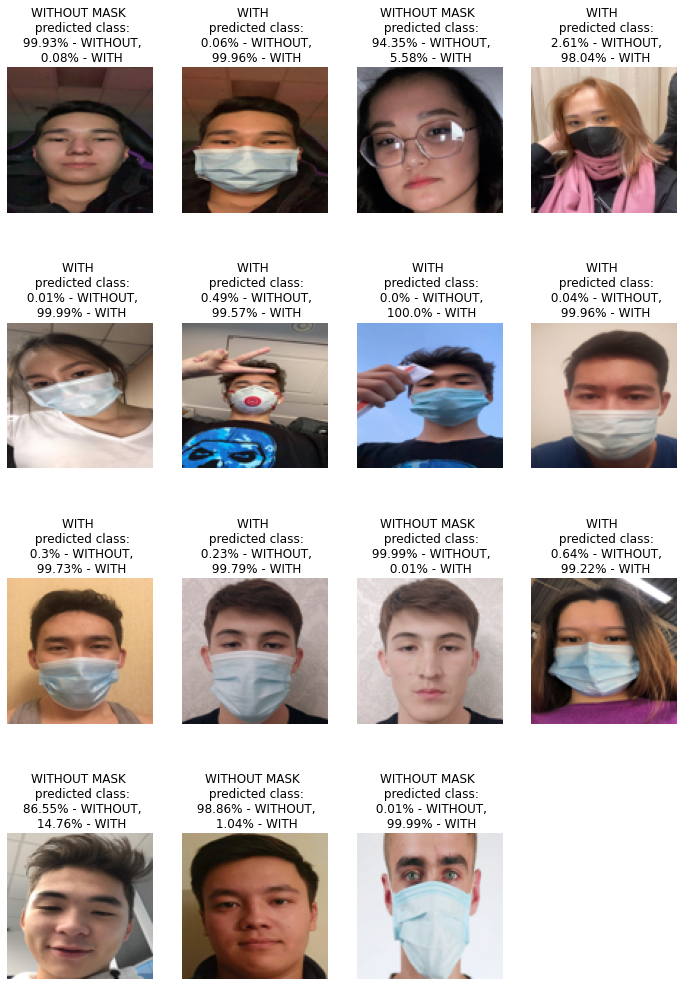

In [22]:
# Plotting groupmates images
plt.figure(figsize=(12, 18))
for i in range(0, 15):
    plt.subplot(4, 4, i+1)
    plt.imshow(arr[i+0])
    if labels[i+0] == 0:
        plt.title(f'WITHOUT MASK \n predicted class:\n {round(saved_model.predict(arr)[i+0][0]*100, 2)}% - WITHOUT,\n {round(saved_model.predict(arr)[i+0][1]*100, 2)}% - WITH')
    else:
        plt.title(f'WITH \n predicted class:\n {round(saved_model.predict(arr)[i+0][0]*100, 2)}% - WITHOUT,\n {round(saved_model.predict(arr)[i+0][1]*100, 2)}% - WITH')
    plt.axis('off')

## Conclusion

To conclude, we developed a model according to the task, namely, a Convolutional Neural Networks, which is implemented by the Conv2D class. Our model predicts the relationship of a person to one of 2 classes ("With Mask"/ "Without Mask"). As you can see, we predicted images of our groupmates, and the model gave good results. 